#  library

main() 함수 내 crawler() 함수 수행

In [2]:
 # -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
fname = '한국행정구역분류_2022.1.1.기준.xlsx'
data_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})
data_region[1].drop('Unnamed: 0', axis=1, inplace=True)
data_citydo_all = data_region[1]['시도'][1:]
data_citydo_unique = data_citydo_all.unique()
booleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]
data_citydo_unique_notna = data_citydo_unique[booleanArray1]
data_citydo_unique_notna
data_citygungu_all = data_region[1]['시군구'][1:]
data_citygungu_unique = data_citygungu_all.unique()
data_citygungu_unique
"""

"\nfname = '한국행정구역분류_2022.1.1.기준.xlsx'\ndata_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})\ndata_region[1].drop('Unnamed: 0', axis=1, inplace=True)\ndata_citydo_all = data_region[1]['시도'][1:]\ndata_citydo_unique = data_citydo_all.unique()\nbooleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]\ndata_citydo_unique_notna = data_citydo_unique[booleanArray1]\ndata_citydo_unique_notna\ndata_citygungu_all = data_region[1]['시군구'][1:]\ndata_citygungu_unique = data_citygungu_all.unique()\ndata_citygungu_unique\n"

# 크롤링

- 크롤링 해오는 것 : 링크,제목,신문사,내용요약본
- 키워드 : 붉은물, 적수, 유충


- 내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장

In [3]:
cos = []

In [4]:
flag_save = 0

maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  # 1
sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") # 0

s_date = '2019.08.08' # 2019.05.10  2019.05.20  2019.05.30  2019.06.09  2019.06.19  2019.06.29  2019.07.09  2019.07.19  2019.07.29  2019.08.08
e_date = '2019.08.17' # 2019.05.19  2019.05.29  2019.06.08  2019.06.18  2019.06.28  2019.07.08  2019.07.18  2019.07.28  2019.08.07  2019.08.17

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='C:/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

#크롤링 시작
list_region = ['인천']

for region in list_region:
  list_keyword = ['붉은물']
  for keyword in list_keyword:
    query = region +' ' + keyword
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
        atags = soup.find_all('a', 'news_tit')
        for atag in atags:
            title = atag.get('title')
            title_text.append(title)     #제목
            link_text.append(atag['href'])   #링크주소

        #신문사 추출 (a 태그 중 class 명이 info press인 것)
        source_lists = soup.find_all('a', 'info press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사

        #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
        contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화

        #모든 리스트 딕셔너리형태로 저장
        result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
        df = pd.DataFrame(result)  #df로 변환
        page += 10
        print(df)

if flag_save == 1:
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s %s시 %s분 %s초 merging' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(outputFileName+'.xlsx',sheet_name='sheet1')
    #df.to_csv(outputFileName+'.csv', mode='w')

최대 크롤링할 페이지 수 입력하시오: 1
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
                                  title      source  \
0  포항서도 '붉은 수돗물'?…"수돗물 필터 색이 변했다" 민원 쇄도  조선일보언론사 선정   
1   인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈        한국경제   
2              인천, 붉은 수돗물에 이어 이번엔 역한 냄새        매일경제   
3       ‘인천 붉은 수돗물 사태’ 피해 주민들, 집단 소송 예고         뉴스핌   
4   [단독] 인천 '붉은 수돗물' 감지 못한 탁도계, 조작가능 확인  TV조선언론사 선정   
5             인천 공촌정수장 탁도계 업체 "고장 안 났다"       인천투데이   
6           포항도 '붉은 수돗물'…원인 불명 '불안감 확산'         MBC   
7                      인천시 붉은물 피해 보상 돌입        인천일보   
8                인천시 붉은수돗물 보상안에…등돌린 주민들        매일경제   
9               포항 남구서 '붉은 수돗물'…물 비린내까지      한국경제TV   

                                            contents  \
0  그러나 포항시 측은 "인천의 붉은 수돗물 사태와는 다르다"고 했다. 포항시 관계자는...   
1  “더 이상 민·형사상의 소(訴)를 제기하지 않을 것임을 서약하며 신청합니다.” 지난...   
2  최근 팔당·풍납 취수장에 조류가 이상 증식하면서 풍납 원수에서는 1ℓ당 최고 46n...   
3  이어 “박남춘 인천시장이 5일 붉은 물 사태 종료와 정상화를 선언하고 피해 보상안을...   
4  인천에서 '붉은 수돗물'이 나왔을 당시에 탁도검사는 계속 정상으로 나왔습니다. 그래... 

####### 정제화 비교

In [8]:
contents_lists[0]

<a class="api_txt_lines dsc_txt_wrap" href="http://news.chosun.com/site/data/html_dir/2019/08/11/2019081101670.html?utm_source=naver&amp;utm_medium=original&amp;utm_campaign=news" onclick="return goOtherCR(this, 'a=nws*h.body&amp;r=1&amp;i=880000ED_000000000000000003466473&amp;g=023.0003466473&amp;u='+urlencode(this.href));" target="_blank">그러나 포항시 측은 "<mark>인천</mark>의 <mark>붉은</mark> 수돗물 사태와는 다르다"고 했다. 포항시 관계자는 "물을 공급하는 경로를 무리하게 바꿔 노폐물이 떨어진 <mark>인천</mark>시와 달리 포항시는 급수 경로 변경이 없었다"면서 "수돗물 역시 음용수질기준을 충족한다"고 했다. 기준을 충족한 수돗물도 필터와 맞닿는 과정에서 내부 물질로...</a>

In [9]:
contents_text[0]

'그러나 포항시 측은 "인천의 붉은 수돗물 사태와는 다르다"고 했다. 포항시 관계자는 "물을 공급하는 경로를 무리하게 바꿔 노폐물이 떨어진 인천시와 달리 포항시는 급수 경로 변경이 없었다"면서 "수돗물 역시 음용수질기준을 충족한다"고 했다. 기준을 충족한 수돗물도 필터와 맞닿는 과정에서 내부 물질로...'

In [237]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
dfNew = pd.Series(list_search)
df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)

corpus = df_tfidf_base
corpus

C:\Users\qpflw\AppData\Local\Temp/ipykernel_2428/123471369.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)


0     그러나 포항시 측은 "인천의 붉은 수돗물 사태와는 다르다"고 했다. 포항시 관계자는...
1     “더 이상 민·형사상의 소(訴)를 제기하지 않을 것임을 서약하며 신청합니다.” 지난...
2     최근 팔당·풍납 취수장에 조류가 이상 증식하면서 풍납 원수에서는 1ℓ당 최고 46n...
3     이어 “박남춘 인천시장이 5일 붉은 물 사태 종료와 정상화를 선언하고 피해 보상안을...
4     인천에서 '붉은 수돗물'이 나왔을 당시에 탁도검사는 계속 정상으로 나왔습니다. 그래...
5     지난 5월 30일 인천 붉은 물 사태가 시작된 후 환경부는 조사를 벌여 중간 조사 ...
6     ◀ 앵커 ▶ 인천에서 붉은 수돗물 사태가 논란을 빚은 데 이어, 경북 포항시에서도 ...
7     ▲ 인천일보, INCHEONILBO 인천시가 붉은 수돗물 사태와 관련해 주민 피해 ...
8     앞서 인천시는 붉은 수돗물 사태의 발단이 된 공촌수계지역 수돗물 피해 주민과 소상공...
9     또 "망간은 미네랄 한 종류로 다량 섭취하면 문제가 생기지만 미량은 인체에 해가 없...
10                                               인천 붉은물
dtype: object

In [238]:
df

,title,source,contents,link
0,"포항서도 '붉은 수돗물'?…""수돗물 필터 색이 변했다"" 민원 쇄도",조선일보언론사 선정,"그러나 포항시 측은 ""인천의 붉은 수돗물 사태와는 다르다""고 했다. 포항시 관계자는...",http://news.chosun.com/site/data/html_dir/2019...
1,인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈,한국경제,“더 이상 민·형사상의 소(訴)를 제기하지 않을 것임을 서약하며 신청합니다.” 지난...,https://www.hankyung.com/society/article/20190...
2,"인천, 붉은 수돗물에 이어 이번엔 역한 냄새",매일경제,최근 팔당·풍납 취수장에 조류가 이상 증식하면서 풍납 원수에서는 1ℓ당 최고 46n...,http://news.mk.co.kr/newsRead.php?year=2019&no...
3,"‘인천 붉은 수돗물 사태’ 피해 주민들, 집단 소송 예고",뉴스핌,이어 “박남춘 인천시장이 5일 붉은 물 사태 종료와 정상화를 선언하고 피해 보상안을...,http://www.newspim.com/news/view/20190811000116
4,"[단독] 인천 '붉은 수돗물' 감지 못한 탁도계, 조작가능 확인",TV조선언론사 선정,인천에서 '붉은 수돗물'이 나왔을 당시에 탁도검사는 계속 정상으로 나왔습니다. 그래...,http://news.tvchosun.com/site/data/html_dir/20...
5,"인천 공촌정수장 탁도계 업체 ""고장 안 났다""",인천투데이,지난 5월 30일 인천 붉은 물 사태가 시작된 후 환경부는 조사를 벌여 중간 조사 ...,http://www.incheontoday.com/news/articleView.h...
6,포항도 '붉은 수돗물'…원인 불명 '불안감 확산',MBC,"◀ 앵커 ▶ 인천에서 붉은 수돗물 사태가 논란을 빚은 데 이어, 경북 포항시에서도 ...",http://imnews.imbc.com/replay/2019/nwtoday/art...
7,인천시 붉은물 피해 보상 돌입,인천일보,"▲ 인천일보, INCHEONILBO 인천시가 붉은 수돗물 사태와 관련해 주민 피해 ...",http://www.incheonilbo.com/news/articleView.ht...
8,인천시 붉은수돗물 보상안에…등돌린 주민들,매일경제,앞서 인천시는 붉은 수돗물 사태의 발단이 된 공촌수계지역 수돗물 피해 주민과 소상공...,http://news.mk.co.kr/newsRead.php?year=2019&no...
9,포항 남구서 '붉은 수돗물'…물 비린내까지,한국경제TV,"또 ""망간은 미네랄 한 종류로 다량 섭취하면 문제가 생기지만 미량은 인체에 해가 없...",http://news.wowtv.co.kr/NewsCenter/News/Read?a...


# 벡터화

In [239]:
tfidfv = TfidfVectorizer().fit(corpus)
tfidfv_array = tfidfv.transform(corpus).toarray()

In [240]:
tfidfv_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.15662046, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.15599417, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# 유사도

In [241]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidfv_array, tfidfv_array)) 
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.006263,0.018313,0.005759,0.045474,0.005295,0.075068,0.022026,0.114743,0.073436,0.000000
1,0.006263,1.000000,0.046683,0.046563,0.041968,0.065199,0.043153,0.023810,0.006584,0.021855,0.068642
2,0.018313,0.046683,1.000000,0.000000,0.012141,0.021809,0.000000,0.000000,0.019251,0.000000,0.058438
3,0.005759,0.046563,0.000000,1.000000,0.012362,0.062745,0.052513,0.047294,0.031736,0.000000,0.000000
4,0.045474,0.041968,0.012141,0.012362,1.000000,0.094027,0.099912,0.029771,0.065507,0.037682,0.000000
5,0.005295,0.065199,0.021809,0.062745,0.094027,1.000000,0.017369,0.005505,0.005566,0.000000,0.058025
6,0.075068,0.043153,0.000000,0.052513,0.099912,0.017369,1.000000,0.060395,0.117788,0.040710,0.000000
7,0.022026,0.023810,0.000000,0.047294,0.029771,0.005505,0.060395,1.000000,0.065080,0.023700,0.000000
8,0.114743,0.006584,0.019251,0.031736,0.065507,0.005566,0.117788,0.065080,1.000000,0.025139,0.000000
9,0.073436,0.021855,0.000000,0.000000,0.037682,0.000000,0.040710,0.023700,0.025139,1.000000,0.000000


In [242]:
len_contents = len(cos_sim_df)-1
len_contents

10

In [243]:
cos_sim_df_sorted = cos_sim_df.iloc[len_contents].sort_values(ascending=False)
cos_sim_df_sorted

10    1.000000
1     0.068642
2     0.058438
5     0.058025
0     0.000000
3     0.000000
4     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
Name: 10, dtype: float64

In [244]:
cos_sim_df_sorted_others = cos_sim_df_sorted[1:]
cos_sim_df_sorted_others

cos_sim_df_sorted_others_sum = cos_sim_df_sorted_others.sum()/10 * 100 # percent 지표
print(cos_sim_df_sorted_others_sum)

1.8510460130595676


In [245]:
cos.append(cos_sim_df_sorted_others_sum)
cos

[0.8105423965852111,
 0.0,
 2.8757996002692487,
 2.7084720834747467,
 3.0556485967598164,
 2.766719825676044,
 3.406954651689611,
 1.4558573116619766,
 2.2962390958521595,
 1.8510460130595676]

In [251]:
cos_df = pd.DataFrame(cos)
cos_df

,0
0,0.810542
1,0.000000
2,2.875800
3,2.708472
4,3.055649
5,2.766720
6,3.406955
7,1.455857
8,2.296239
9,1.851046


# 시각화

In [246]:
plt.rc("font", family="Malgun Gothic") # window

Text(0.5, 1.0, '네이버 코사인 유사도(%)')

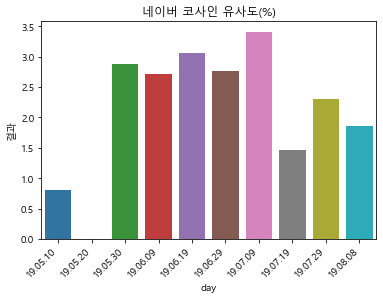

In [253]:
df1=pd.DataFrame({'day':('19.05.10','19.05.20','19.05.30','19.06.09','19.06.19','19.06.29', '19.07.09', '19.07.19', '19.07.29', '19.08.08'),'결과':cos})
p = sns.barplot(data = df1, x ='day',y='결과')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
p.set_title("네이버 코사인 유사도(%)")

In [103]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
list_search

'인천 붉은물'